###### imports 

In [1]:
import torch.nn as nn
import torch

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from data.dataloader import data_generator_real_data
from models.losses import loss_function_mat
from estimator.MLE import torch_cov_pairwise

In [4]:
from data.real_dataloader import real_data_pipeline

In [5]:
from models.gru_denoiser import BiGRUSpectralDenoiser

In [6]:
from training.trainer import Trainer

## NN

In [7]:
mse = nn.MSELoss()

In [8]:
N_min = 100
N_max = 400
T_min = 30
T_max = 70
batch_size=100

### Training loop on Real Data

In [9]:
model_real_data = BiGRUSpectralDenoiser(hidden_size=128) # hidden_size to be tunned 
# lr, weight_decay, batch_size, epochs, hidden_size to be tunned

In [10]:
dataset = real_data_pipeline(
    batch_size,
    date_bounds=('1995-01-01','2015-01-01'),
    n_days_out = T_max+10,
    n_days_in = T_max,
    shift = 0,
    n_stocks = N_max,
    market_cap_range = (1000, 3000),
    sequential = False,
    return_generator = False,
)

In [ ]:
real_data_trainer = Trainer(
    model=model_real_data, is_train_on_real_data = True, loss_function=loss_function_mat, data_generator=data_generator_real_data, lr = 5e-4, weight_decay=1e-6,
    batch_size=batch_size, epochs=50, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max, log_interval=10, accumulate_steps=2, dataset=dataset, missing_constant = 2
)
# need to epochs to be big when there is lot of choise for N and T 
# need for big batch_size when df is big
losses_real_data = real_data_trainer.train()

Starting training for 50 epochs…
Epoch 2/50 — loss: 0.06927782
Epoch 4/50 — loss: 0.04323784
Epoch 6/50 — loss: 0.03886823
Epoch 8/50 — loss: 0.03742928
Epoch 10/50 — loss: 0.03193093
Epoch 12/50 — loss: 0.02544000
Epoch 14/50 — loss: 0.07855292
Epoch 16/50 — loss: 0.03272821
Epoch 18/50 — loss: 0.02771751
Epoch 20/50 — loss: 0.05797648
Epoch 22/50 — loss: 0.13803017
Epoch 24/50 — loss: 0.03648944
Epoch 26/50 — loss: 0.04533635
Epoch 28/50 — loss: 0.03147867
Epoch 30/50 — loss: 0.08199421
Epoch 32/50 — loss: 0.08079749
Epoch 34/50 — loss: 0.06904628
Epoch 36/50 — loss: 0.05084042
Epoch 38/50 — loss: 0.14232431
Epoch 40/50 — loss: 0.04670143
Epoch 42/50 — loss: 0.05148179
Epoch 44/50 — loss: 0.03603237
Epoch 46/50 — loss: 0.02525923
Epoch 48/50 — loss: 0.03340830
Epoch 50/50 — loss: 0.02455132
Training complete.


0.00000568

identified 1 major problem of divergence : 
- when T and N are changing, loss Is not converging


In [12]:
# save the model
torch.save(model_real_data.state_dict(), "models/spectral_denoiser_model_real_data.pth")

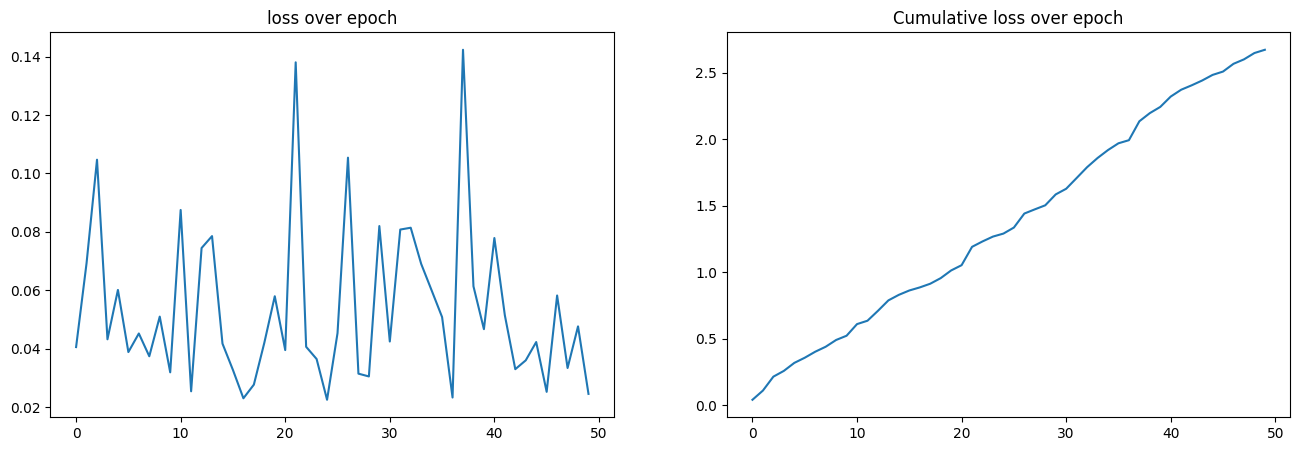

In [13]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(losses_real_data)
plt.title("loss over epoch")
plt.subplot(1,2,2)
plt.plot(np.cumsum(losses_real_data))
plt.title("Cumulative loss over epoch")
plt.savefig("images/training_loss.png")
plt.show()

In [14]:
state_dict_real_data = torch.load("models/spectral_denoiser_model_real_data.pth")
model_real_data.load_state_dict(state_dict_real_data)
model_real_data.eval()

BiGRUSpectralDenoiser(
  (gru): GRU(6, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (activation): Softplus(beta=1.0, threshold=20.0)
)

### Out of sample comparaison 1 — surface

In [15]:
batch_size_oos = 25

N_list_test = np.linspace(N_min, N_max, 10, dtype=int)
T_list_test = np.linspace(T_min, T_max, 7, dtype=int)

In [16]:
losses_value = []

In [17]:
for n in N_list_test:
    for t in T_list_test:
        input_seq, Q_emp_oos_i, R_oos, T_t = next(data_generator_real_data(N_min=n, N_max=n, T_min=t, T_max=t, dataset=dataset, missing_constant=2))
        lam_pred_test_i = model_real_data(input_seq)
        loss = loss_function(lam_pred_test_i, Q_emp_oos_i, torch_cov_pairwise(R_oos), T_t).item()
        losses_value.append(loss)

In [18]:
# meshing
loss_grid = np.array(losses_value).reshape(len(np.array(N_list_test)), len(np.array(T_list_test)))
N_mesh, T_mesh = np.meshgrid(np.array(N_list_test), np.array(T_list_test), indexing='ij')

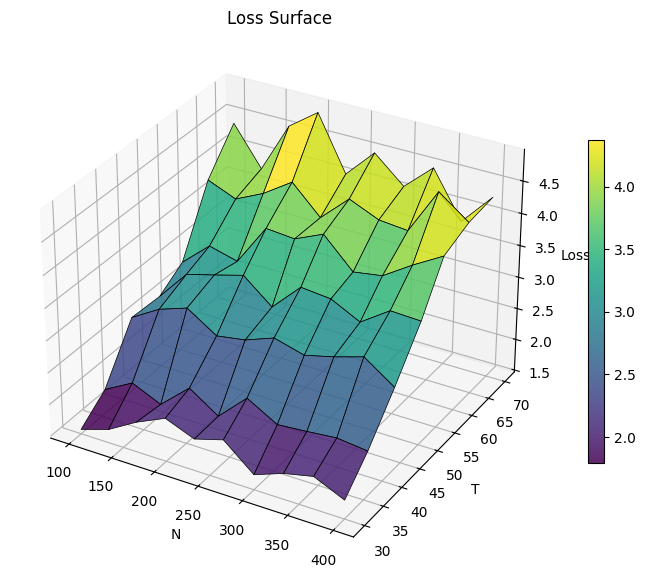

In [19]:
# plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(N_mesh, T_mesh, loss_grid,
                       cmap='viridis',
                       edgecolor='k',
                       linewidth=0.5,
                       alpha=0.85)

ax.set_xlabel("N")
ax.set_ylabel("T")
ax.set_zlabel("Loss")
ax.set_title("Loss Surface")

fig.colorbar(surf, shrink=0.6)
plt.savefig('images/loss_surface.png')
plt.show()

Flat : it means there is no incoherence 

### Out of sample comparaison 2

In [27]:
batch_size_oos = 500

In [28]:
is_real_data=True

In [29]:
input_seq_miss, Q_emp_miss, R_oos_miss, T          = next(data_generator_real_data(missing_constant = 2, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max, dataset=dataset))
input_seq_no_miss, Q_emp_no_miss, R_oos_no_miss, T = next(data_generator_real_data(missing_constant = 1, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max, dataset=dataset))

There is only one N and T, or we know that if N>>T we have lot of noise hence our NN has to be better !

In [30]:
lam_emp_miss     = input_seq_miss[:, :, 0]
lam_emp_no_miss  = input_seq_no_miss[:, :, 0]
lam_pred_miss    = model_real_data(input_seq_miss)
lam_pred_no_miss = model_real_data(input_seq_no_miss)

In [ ]:
cov_true_miss    = torch_cov_pairwise(R_oos_miss)
cov_true_no_miss = torch_cov_pairwise(R_oos_no_miss)

Comparaison eigenvalues $\lambda$ (what matters)

In [ ]:
loss_pred_lam_miss        = loss_function(lam_emp_miss, Q_emp_miss, cov_true_miss, T)
loss_pred_lam_no_miss     = loss_function(lam_emp_no_miss, Q_emp_no_miss, cov_true_no_miss, T)
loss_emp_lam_miss         = loss_function(lam_pred_miss, Q_emp_miss, cov_true_miss, T)
loss_emp_lam_no_miss      = loss_function(lam_pred_no_miss, Q_emp_no_miss, cov_true_no_miss, T)

print(f"Portfolio profit after miss + NN:         {loss_pred_lam_miss:.6f}")
print(f"Portfolio profit after no miss + NN :     {loss_pred_lam_no_miss:.6f}")
print(f"Portfolio profit after miss + no NN :     {loss_emp_lam_miss:.6f}")
print(f"Portfolio profit after no miss  + no NN : {loss_emp_lam_no_miss:.6f}")
#print(f"Portfolio profit after no miss QIS :      {loss_lam_QIS:.6f}")

# print(f"MSE Shaffer  : {mse_shaffer_test_lam:.6f}")

Portfolio profit after miss + NN:         2.759813
Portfolio profit after no miss + NN :     2.299421
Portfolio profit after miss + no NN :     2.990784
Portfolio profit after no miss  + no NN : 3.767579


Graphique : 

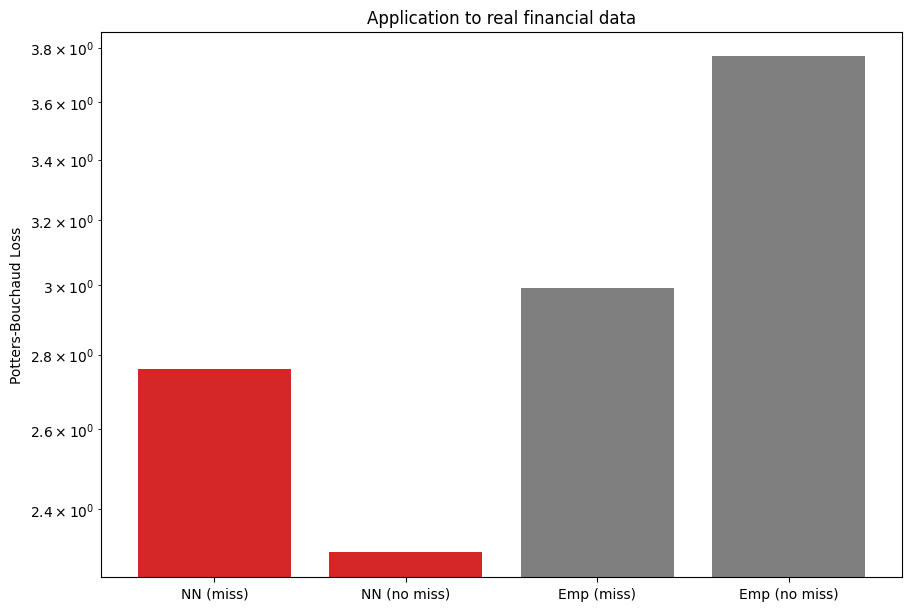

In [33]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)']
values = [loss_pred_lam_miss.item(), loss_pred_lam_no_miss.item(), loss_emp_lam_miss.item(), loss_emp_lam_no_miss.item()]
colors = ['tab:red','tab:red','tab:gray','tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.title("Application to real financial data")
plt.yscale('log')
plt.ylabel('Potters-Bouchaud Loss')
plt.grid(axis='y', ls='--', alpha=.5)
plt.show()


not convincing : our NN doesn't give us any advantage over classical empirical estimator => hesitating to rebuild/dig into data gen

In [42]:
input_seq_miss, Q_emp_miss, R_oos_miss, T          = next(data_generator_real_data(missing_constant = 2, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max, dataset=dataset))


In [44]:
R_oos_miss[0]

tensor([[-0.6988, -0.2749, -0.6279,  ...,  0.0661,  0.3053, -0.0127],
        [ 0.6240,  0.0454,  0.0454,  ...,  0.6622,  0.0454,  0.0454],
        [ 2.3654, -0.1015, -1.6653,  ..., -2.1752,  1.3437, -0.6276],
        ...,
        [-0.1571, -1.5048, -1.8685,  ..., -0.1007,  0.2279, -0.9093],
        [ 0.5373, -0.1072, -0.1072,  ...,  2.1810,  0.9887,  0.1611],
        [ 0.1519,  0.3119,  0.4152,  ...,  0.5286, -0.8435, -0.0639]])